# Unet3D-Desnity-Metrics

In [1]:
%pylab inline
import matplotlib.pyplot as pl
import unet
from scipy.signal import medfilt

import logging
import sys
from collections import namedtuple
from itertools import chain

import emsa

import numpy as np
import scipy
from scipy import ndimage
from scipy import ndimage as ndi
from scipy.misc import imsave
from scipy.spatial import distance_matrix
from scipy.sparse.csgraph import connected_components
import matplotlib.pyplot as plt

import torch
from torch.autograd import Variable
from torch import optim

import unet
from unet.utils import BinCounter

logger = logging.getLogger(__name__)

plt.rcParams["figure.figsize"] = (12, 6)

Populating the interactive namespace from numpy and matplotlib


In [2]:
unet.config_logger("/dev/null")

In [3]:
# DensityPixel
path = "/UNet-Density-ClassicImplementation-Test5-New-100"
sample = "/summary_185000.h5"
summary = unet.summary.load_h5("/cvlabdata2/home/mas" + path + sample)

# DensityMap
# path = "/UNet-Density-Test4-OriginalDataSet"
# sample = "/summary_050000.h5"
# summary = unet.summary.load_h5("/cvlabdata2/home/mas" + path + sample)

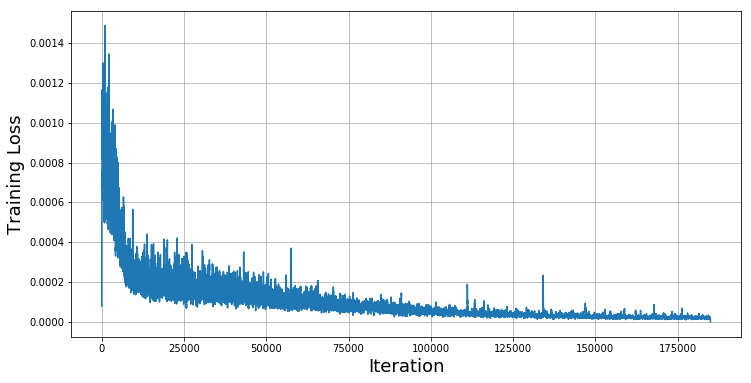

In [4]:
# Printing the training loss
iters, losses = summary.get("training.loss")
plt.plot(iters,medfilt(losses, 51))
plt.grid()
plt.ylabel("Training Loss", fontsize=18)
plt.xlabel("Iteration", fontsize=18)


20000


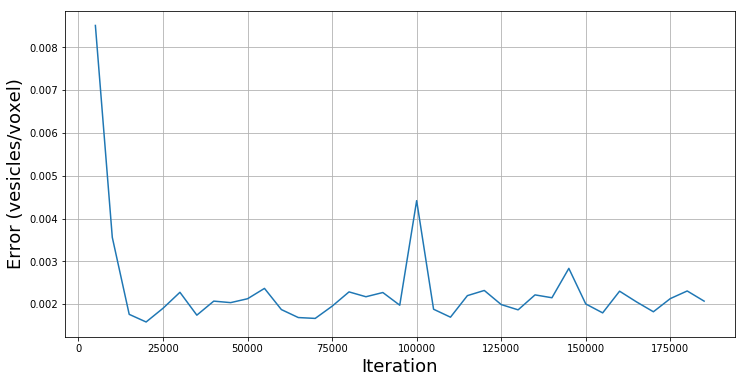

In [5]:
# Printing the error computed using random boxes during the testing
iters, error = summary.get("testing.total_error")
plot(iters, error)
plt.grid()
print(iters[error.argmin()])
plt.ylabel("Error (vesicles/voxel)", fontsize=18)
plt.xlabel("Iteration", fontsize=18)

In [6]:
error.min()

0.001586645230020139

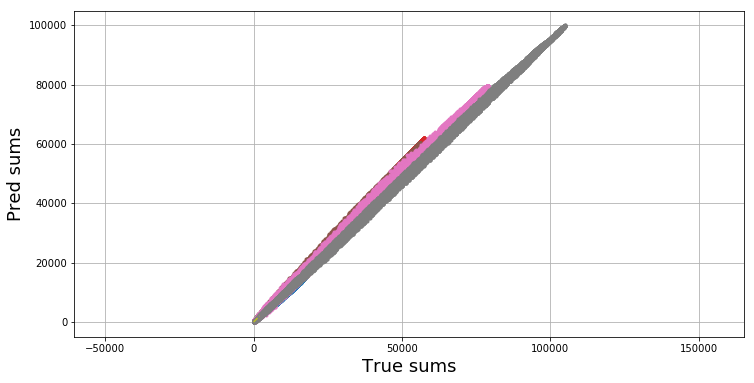

In [7]:
# Printing a graphic with the relation between the number of vesicles in the prediction and in the original data.
iters, true_sums = summary.get("testing.true_sums")
pred_sums = summary.get("testing.pred_sums")[1]

best_it = (iters == 20000).argmax()

plt.plot(true_sums[best_it].T, pred_sums[best_it].T, '.')
plt.plot([0, 2000], [0, 2000], '--')
plt.grid()
plt.axis('equal')
plt.ylabel("Pred sums", fontsize=18)
plt.xlabel("True sums", fontsize=18)

In [8]:
num_classes = 1 # Density
hint_patch_shape=(82, 82, 82)
logger.info("Creating the network...")
unet_config = unet.UNetConfig(steps=2,
                              ndims=3,
                              num_classes=num_classes,
                              first_layer_channels=64,
                              num_input_channels=1,
                              two_sublayers=True)

in_patch_shape, out_patch_shape = unet_config.in_out_shape(hint_patch_shape)

unet_clsf = unet.UNetRegressor(unet_config).cuda()

unet_trainer = unet.trainer.Trainer(lambda niter : None,
                            save_every=5000,
                            save_path="/cvlabdata2/home/mas/" + path,
                            managed_objects=unet.trainer.managed_objects({"network": unet_clsf}),
                            test_function=None,
                            test_every=0)

2018-02-05 17:58:36,460 [__main__] Creating the network...


In [9]:
testing_x1 = np.float32(unet.load_volume("/cvlabdata1/home/mas/vesicles/hipp_testing/Bouton 1/img.tif")) / 255.0
testing_x = np.float32(unet.load_volume("/cvlabdata1/home/mas/vesicles/striatum_testing/Bouton 4/img.tif")) / 255.0

In [10]:
unet_trainer.load(20000) # ALERT!!!: CHANGE to the best iteration
hint_patch_shape=(82, 82, 82)
pred = unet.predict_in_blocks(unet_clsf, testing_x, hint_patch_shape,
                                          verbose=False)[0]


2018-02-05 17:58:39,812 [unet.trainer] Loading '/cvlabdata2/home/mas//UNet-Density-ClassicImplementation-Test5-New-100/network_020000.pth'...
2018-02-05 17:58:39,880 [unet.trainer] Loading '/cvlabdata2/home/mas//UNet-Density-ClassicImplementation-Test5-New-100/summary_020000.h5'...


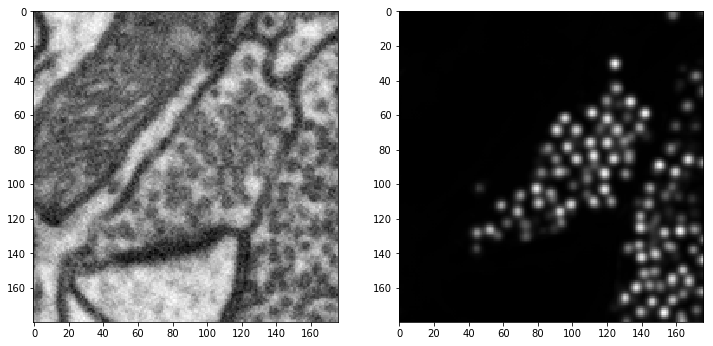

In [11]:
# Results in the best stack
i = 180
plt.subplot(1, 2, 1)
plt.imshow(testing_x[i])
plt.subplot(1, 2, 2)
plt.imshow(pred[i])

In [12]:
unet_trainer.load(20000) # ALERT!!!: CHANGE to the best iteration
hint_patch_shape=(82, 82, 82)
pred1 = unet.predict_in_blocks(unet_clsf, testing_x1, hint_patch_shape,
                                          verbose=False)[0]

2018-02-05 17:59:57,857 [unet.trainer] Loading '/cvlabdata2/home/mas//UNet-Density-ClassicImplementation-Test5-New-100/network_020000.pth'...
2018-02-05 17:59:57,914 [unet.trainer] Loading '/cvlabdata2/home/mas//UNet-Density-ClassicImplementation-Test5-New-100/summary_020000.h5'...


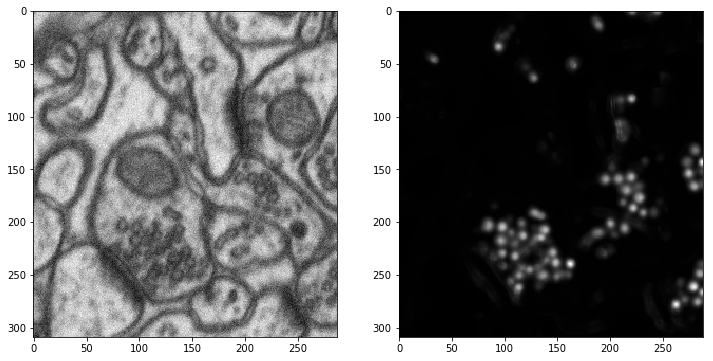

In [13]:
# results in the worst stack
i = 51
plt.subplot(1, 2, 1)
plt.imshow(testing_x1[i])
plt.subplot(1, 2, 2)
plt.imshow(pred1[i])

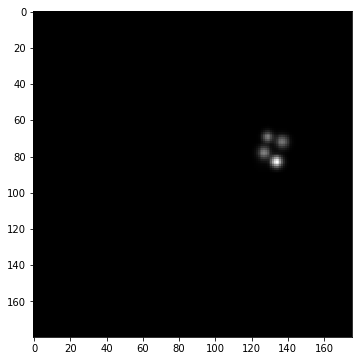

In [14]:
density = np.float32(unet.load_volume("/cvlabdata1/home/mas/vesicles/striatum_testing/Bouton 4/density.tif"))
plt.imshow(density[i])

In [15]:
def reduce_metrics(results):
    
    true_sums = np.array([i.true_sums for i in results])
    pred_sums = np.array([i.pred_sums for i in results])
    volumes = np.array([i.volumes for i in results])

    error = emsa.diff_vesicles_per_voxel(true_sums, pred_sums, volumes)
    
    return Metrics2(error, true_sums, pred_sums, volumes)

In [16]:
vesicle_radius = 4
results = []
mask = np.float32(unet.load_volume("/cvlabdata1/home/mas/vesicles/striatum_testing/Bouton 4/mask.tif"))

Metrics2 = namedtuple('Metrics', ['error', 'true_sums', 'pred_sums', 'volumes'])

true_density = np.float32(unet.load_volume("/cvlabdata1/home/mas/vesicles/striatum_testing/Bouton 4/density.tif"))

true_sums, pred_sums, volumes = emsa.ersa(true_density, pred, mask, 1000000, vesicle_radius)
error = emsa.diff_vesicles_per_voxel(true_sums, pred_sums, volumes)

results.append(Metrics2(error, true_sums, pred_sums, volumes))

total = reduce_metrics(results)
logger.info("\tError: {:.4g} vesicles/voxel. ".format(total.error))

2018-02-05 18:01:09,334 [__main__] 	Error: 0.03796 vesicles/voxel. 


In [17]:
# import tifffile
# tifffile.imsave("/cvlabdata1/home/mas/pred2-density.tif", pred2)